CONJUNTO DE DATOS: Información de Animales
Total de registros: 1568
Total de columnas: 67

Registros después de limpieza: 248

Distribución de clases:
characteristics/diet
Carnivore    108
Omnivore      88
Herbivore     52
Name: count, dtype: int64

Características: ['velocidad', 'peso', 'esperanza_vida', 'num_especies', 'tipo_piel', 'estilo_vida', 'clase_taxonomica']

ENTRENAMIENTO DE MODELOS

✓ Árbol de Decisión entrenado

✓ Máquinas de Vectores de Soporte entrenado

✓ Regresión Logística entrenado

INFORME DE MÉTRICAS

----------------------------------------------------------------------
MODELO                              PRECISIÓN    EXHAUSTIVIDAD   F1-SCORE    
----------------------------------------------------------------------
Árbol de Decisión                   0.6387       0.5733          0.5578      
Máquinas de Vectores de Soporte     0.5675       0.5333          0.5138      
Regresión Logística                 0.5368       0.5333          0.5191      
------------------

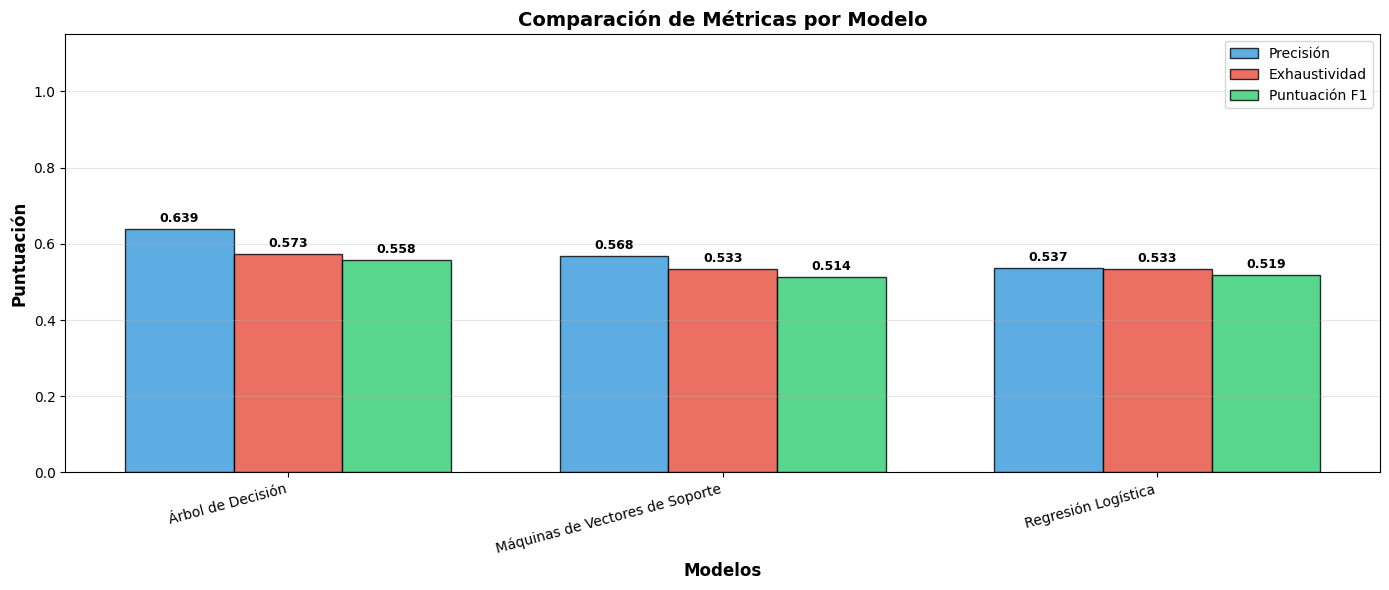

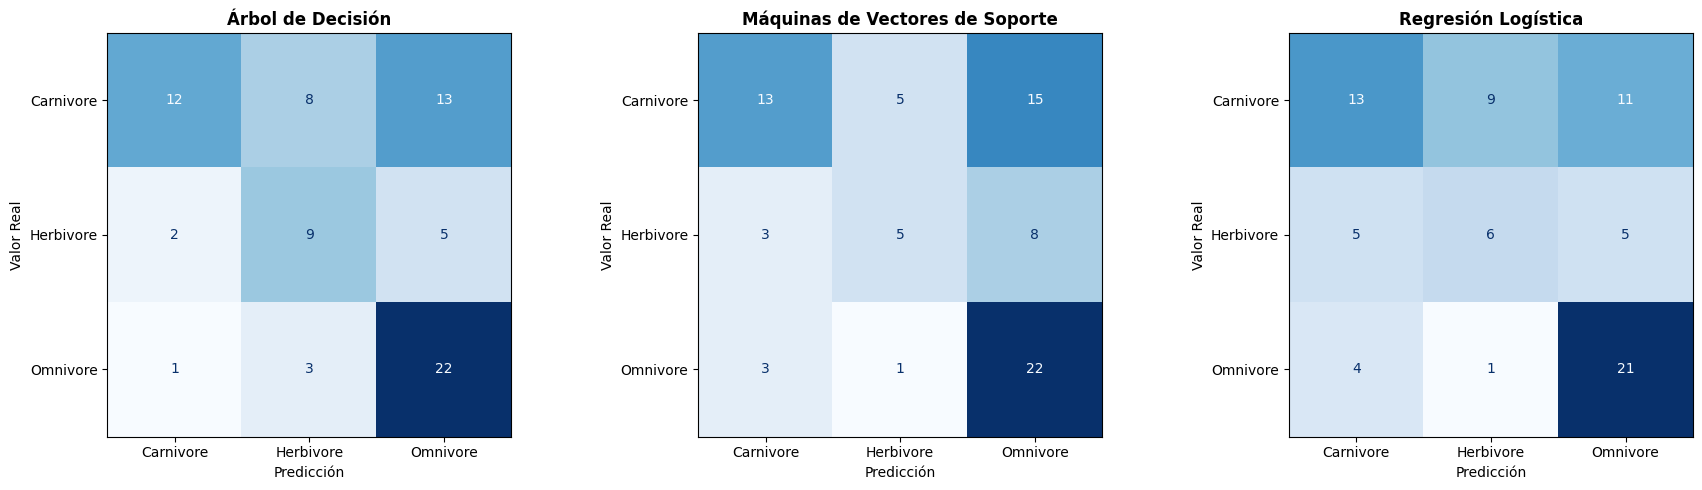


ANÁLISIS CRÍTICO DE RESULTADOS

🏆 MEJOR MODELO: Árbol de Decisión (Puntuación F1: 0.5578)

ANÁLISIS POR MODELO:
------------------------------------------------------------

Árbol de Decisión:
  • Precisión:      0.6387
  • Exhaustividad:  0.5733
  • Puntuación F1:  0.5578
  → Más preciso pero detecta menos positivos verdaderos

Máquinas de Vectores de Soporte:
  • Precisión:      0.5675
  • Exhaustividad:  0.5333
  • Puntuación F1:  0.5138
  → Balance equilibrado entre precisión y exhaustividad

Regresión Logística:
  • Precisión:      0.5368
  • Exhaustividad:  0.5333
  • Puntuación F1:  0.5191
  → Balance equilibrado entre precisión y exhaustividad

------------------------------------------------------------
CONCLUSIONES:
------------------------------------------------------------

1. RANKING de modelos:
   1º Árbol de Decisión: 0.5578
   2º Regresión Logística: 0.5191
   3º Máquinas de Vectores de Soporte: 0.5138



In [12]:
# ===================================
# IMPORTACIONES
# ===================================
!pip install -q datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             ConfusionMatrixDisplay)
import warnings
warnings.filterwarnings('ignore')

# ===================================
# CARGA DE DATOS
# ===================================
df = pd.read_csv("hf://datasets/PenguinPush/animals-info/animals-info.csv")

print("=" * 60)
print("CONJUNTO DE DATOS: Información de Animales")
print("=" * 60)
print(f"Total de registros: {df.shape[0]}")
print(f"Total de columnas: {df.shape[1]}\n")

# ===================================
# PREPROCESAMIENTO
# ===================================
# Variable objetivo: Dieta del animal
df_limpio = df[df['characteristics/diet'].notna()].copy()

# Extraer características numéricas
def extraer_numerico(texto):
    if pd.isna(texto):
        return np.nan
    import re
    numeros = re.findall(r'\d+', str(texto))
    return float(numeros[0]) if numeros else np.nan

# Características
df_limpio['velocidad'] = df_limpio['characteristics/top_speed'].apply(extraer_numerico)
df_limpio['peso'] = df_limpio['characteristics/weight'].apply(extraer_numerico)
df_limpio['esperanza_vida'] = df_limpio['characteristics/lifespan'].apply(extraer_numerico)
df_limpio['num_especies'] = pd.to_numeric(df_limpio['characteristics/number_of_species'], errors='coerce')

# Codificar variables categóricas
codif_piel = LabelEncoder()
codif_estilo_vida = LabelEncoder()
codif_clase = LabelEncoder()

df_limpio['tipo_piel'] = codif_piel.fit_transform(df_limpio['characteristics/skin_type'].fillna('Desconocido'))
df_limpio['estilo_vida'] = codif_estilo_vida.fit_transform(df_limpio['characteristics/lifestyle'].fillna('Desconocido'))
df_limpio['clase_taxonomica'] = codif_clase.fit_transform(df_limpio['taxonomy/class'].fillna('Desconocido'))

# Seleccionar características y objetivo
caracteristicas = ['velocidad', 'peso', 'esperanza_vida', 'num_especies',
                   'tipo_piel', 'estilo_vida', 'clase_taxonomica']
objetivo = 'characteristics/diet'

df_final = df_limpio[caracteristicas + [objetivo]].dropna()

X = df_final[caracteristicas]
y = df_final[objetivo]

print(f"Registros después de limpieza: {len(df_final)}")
print(f"\nDistribución de clases:")
print(y.value_counts())
print(f"\nCaracterísticas: {caracteristicas}\n")

# ===================================
# DIVISIÓN Y ESCALADO
# ===================================
X_entreno, X_prueba, y_entreno, y_prueba = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

escalador = StandardScaler()
X_entreno_escalado = escalador.fit_transform(X_entreno)
X_prueba_escalado = escalador.transform(X_prueba)

# ===================================
# ENTRENAMIENTO DE MODELOS
# ===================================
print("=" * 60)
print("ENTRENAMIENTO DE MODELOS")
print("=" * 60)

modelos = {
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42, max_depth=6),
    'Máquinas de Vectores de Soporte': SVC(kernel='rbf', random_state=42),
    'Regresión Logística': LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
}

resultados = {}

for nombre, modelo in modelos.items():
    # Entrenar
    if nombre == 'Árbol de Decisión':
        modelo.fit(X_entreno, y_entreno)
        y_pred = modelo.predict(X_prueba)
    else:
        modelo.fit(X_entreno_escalado, y_entreno)
        y_pred = modelo.predict(X_prueba_escalado)

    # Calcular métricas
    precision = precision_score(y_prueba, y_pred, average='weighted', zero_division=0)
    exhaustividad = recall_score(y_prueba, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_prueba, y_pred, average='weighted', zero_division=0)

    resultados[nombre] = {
        'predicciones': y_pred,
        'precision': precision,
        'exhaustividad': exhaustividad,
        'puntuacion_f1': f1
    }

    print(f"\n✓ {nombre} entrenado")

# ===================================
# INFORME DE MÉTRICAS
# ===================================
print("\n" + "=" * 60)
print("INFORME DE MÉTRICAS")
print("=" * 60)

# Tabla resumen
print("\n" + "-" * 70)
print(f"{'MODELO':<35} {'PRECISIÓN':<12} {'EXHAUSTIVIDAD':<15} {'F1-SCORE':<12}")
print("-" * 70)
for nombre, resultado in resultados.items():
    print(f"{nombre:<35} {resultado['precision']:<12.4f} {resultado['exhaustividad']:<15.4f} {resultado['puntuacion_f1']:<12.4f}")
print("-" * 70)

# Reportes detallados
for nombre, resultado in resultados.items():
    print(f"\n{nombre}:")
    print(classification_report(y_prueba, resultado['predicciones'], zero_division=0))

# ===================================
# GRÁFICOS
# ===================================
print("\n" + "=" * 60)
print("GENERANDO GRÁFICOS")
print("=" * 60)

# 1. Comparación de métricas
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

datos_metricas = {
    'Precisión': [resultados[m]['precision'] for m in modelos.keys()],
    'Exhaustividad': [resultados[m]['exhaustividad'] for m in modelos.keys()],
    'Puntuación F1': [resultados[m]['puntuacion_f1'] for m in modelos.keys()]
}

x = np.arange(len(modelos))
ancho = 0.25
colores = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metrica, valores) in enumerate(datos_metricas.items()):
    desplazamiento = ancho * (idx - 1)
    barras = ax.bar(x + desplazamiento, valores, ancho, label=metrica,
                   color=colores[idx], alpha=0.8, edgecolor='black')

    # Valores en barras
    for barra in barras:
        altura = barra.get_height()
        ax.text(barra.get_x() + barra.get_width()/2., altura + 0.01,
                f'{altura:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
ax.set_ylabel('Puntuación', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Métricas por Modelo', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(modelos.keys(), rotation=15, ha='right')
ax.legend(fontsize=10)
ax.set_ylim([0, 1.15])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_metricas.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nombre, resultado) in enumerate(resultados.items()):
    mc = confusion_matrix(y_prueba, resultado['predicciones'])
    disp = ConfusionMatrixDisplay(confusion_matrix=mc,
                                   display_labels=sorted(y_prueba.unique()))
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d', colorbar=False)
    axes[idx].set_title(f'{nombre}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicción', fontsize=10)
    axes[idx].set_ylabel('Valor Real', fontsize=10)
    axes[idx].grid(False)

plt.tight_layout()
plt.savefig('matrices_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

# ===================================
# ANÁLISIS CRÍTICO
# ===================================
print("\n" + "=" * 60)
print("ANÁLISIS CRÍTICO DE RESULTADOS")
print("=" * 60)

# Mejor modelo
mejor_modelo = max(resultados, key=lambda x: resultados[x]['puntuacion_f1'])
mejor_f1 = resultados[mejor_modelo]['puntuacion_f1']

print(f"\n🏆 MEJOR MODELO: {mejor_modelo} (Puntuación F1: {mejor_f1:.4f})\n")

print("ANÁLISIS POR MODELO:")
print("-" * 60)

for nombre, resultado in resultados.items():
    print(f"\n{nombre}:")

    # Análisis de precisión vs exhaustividad
    diferencia = abs(resultado['precision'] - resultado['exhaustividad'])

    if resultado['precision'] > resultado['exhaustividad'] + 0.05:
        balance = "Más preciso pero detecta menos positivos verdaderos"
    elif resultado['exhaustividad'] > resultado['precision'] + 0.05:
        balance = "Detecta más positivos pero con más falsos positivos"
    else:
        balance = "Balance equilibrado entre precisión y exhaustividad"

    print(f"  • Precisión:      {resultado['precision']:.4f}")
    print(f"  • Exhaustividad:  {resultado['exhaustividad']:.4f}")
    print(f"  • Puntuación F1:  {resultado['puntuacion_f1']:.4f}")
    print(f"  → {balance}")

print("\n" + "-" * 60)
print("CONCLUSIONES:")
print("-" * 60)

# Comparar modelos
puntuaciones_f1 = [(nombre, resultados[nombre]['puntuacion_f1']) for nombre in modelos.keys()]
puntuaciones_f1_ordenadas = sorted(puntuaciones_f1, key=lambda x: x[1], reverse=True)


print(f"""
1. RANKING de modelos:
   1º {puntuaciones_f1_ordenadas[0][0]}: {puntuaciones_f1_ordenadas[0][1]:.4f}
   2º {puntuaciones_f1_ordenadas[1][0]}: {puntuaciones_f1_ordenadas[1][1]:.4f}
   3º {puntuaciones_f1_ordenadas[2][0]}: {puntuaciones_f1_ordenadas[2][1]:.4f}
""")